# VBM in Python

This script will give you a guideline on how to conduct voxel-based morphometry (VBM) in Python. VBM is a technique used to investigate differences in brain anatomy between groups. There are multiple awesome libraries in Python to work with and view neuroimaging data. A few of them are listed below:
- pandas and numpy: general data manipulation libraries
- nibabel: to read and write neuroimaging data
- nilearn: to perform statistical analysis and visualization


We will use the [COBRE dataset](https://fcon_1000.projects.nitrc.org/indi/retro/cobre.html) as an example. This dataset contains structural MRI data from 75 healthy controls and 72 patients with schizophrenia and is openly available online.

In [67]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm

import seaborn as sns 
import matplotlib.pyplot as plt

# ROI-based analysis

## Load the data

In [68]:
# load the FreeSurfer output
cobre_ct_lh = pd.read_csv('example_data/aparc_COBRE_lh_CT.txt', sep='\t')
cobre_ct_rh = pd.read_csv('example_data/aparc_COBRE_rh_CT.txt', sep='\t')

# rename the first column (containing subject IDs)
cobre_ct_lh.rename(columns={'lh.aparc.thickness': 'SubjID'}, inplace=True)  # don't forget to set inplace=True, otherwise it will not be changed permanently
cobre_ct_rh.rename(columns={'rh.aparc.thickness': 'SubjID'}, inplace=True)

# combine hemispheres into one dataframe (delete columns 'BrainSegVolNotVent' and 'eTIV' in rh file, otherwise it will be doubled in the final dataframe)
cobre_ct = cobre_ct_lh.merge(cobre_ct_rh.drop(['BrainSegVolNotVent', 'eTIV'], axis=1), on='SubjID')
display(cobre_ct.head())

# look at the columns (also check that happens if you don't drop the columns in the previous step)
# display(cobre_ct.columns)

,SubjID,lh_bankssts_thickness,lh_caudalanteriorcingulate_thickness,lh_caudalmiddlefrontal_thickness,lh_cuneus_thickness,lh_entorhinal_thickness,lh_fusiform_thickness,lh_inferiorparietal_thickness,lh_inferiortemporal_thickness,lh_isthmuscingulate_thickness,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,A00000300,2.400,2.228,2.481,1.861,2.807,2.427,2.324,2.589,2.143,...,2.271,2.631,2.049,2.717,2.422,2.920,3.627,2.268,2.763,2.38138
1,A00000368,2.511,2.429,2.423,2.011,3.361,2.595,2.423,2.541,2.343,...,2.279,2.525,2.087,2.859,2.569,2.434,3.625,2.487,2.689,2.39016
2,A00000456,2.218,2.059,2.233,1.659,2.953,2.359,2.108,2.464,2.213,...,2.248,2.438,1.969,2.494,2.398,3.010,3.760,2.142,2.706,2.24432
3,A00000541,2.354,2.709,2.556,1.759,3.310,2.448,2.290,2.773,2.376,...,2.529,2.770,1.700,2.442,2.212,3.227,4.009,2.247,2.855,2.28426
4,A00000838,2.542,2.372,2.640,1.806,3.217,2.547,2.458,2.469,2.309,...,2.254,2.695,2.369,2.725,2.575,2.577,3.725,2.518,2.940,2.46811


In [69]:
# load the subject's meta data
cobre_meta = pd.read_csv('example_data/COBRE_meta.csv')
display(cobre_meta.head())

,SubjID,Dx,Age,Sex,AP,CPZ,AO,DURILL,PANSSTOT,PANSSPOS,PANSSNEG,SAPSTOT,SANSTOT,HAND,PARENTSES,IQ
0,A00000300,0,35,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5.0,114.0
1,A00000368,1,52,1,2.0,50.0,16.0,36.0,63.0,19.0,16.0,NaN,NaN,0,4.0,100.0
2,A00000456,1,53,1,2.0,75.0,16.0,37.0,59.0,11.0,14.0,NaN,NaN,0,4.0,84.0
3,A00000541,1,48,2,NaN,87.1,31.0,17.0,62.0,21.0,9.0,NaN,NaN,0,7.0,99.0
4,A00000838,1,28,1,2.0,1000.0,22.0,6.0,55.0,8.0,18.0,NaN,NaN,0,NaN,108.0


In [70]:
# merge meta and imaging data
data = pd.merge(cobre_meta, cobre_ct, on='SubjID', how='inner')
display(data.head())

,SubjID,Dx,Age,Sex,AP,CPZ,AO,DURILL,PANSSTOT,PANSSPOS,...,rh_rostralmiddlefrontal_thickness,rh_superiorfrontal_thickness,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness
0,A00000300,0,35,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2.271,2.631,2.049,2.717,2.422,2.920,3.627,2.268,2.763,2.38138
1,A00000368,1,52,1,2.0,50.0,16.0,36.0,63.0,19.0,...,2.279,2.525,2.087,2.859,2.569,2.434,3.625,2.487,2.689,2.39016
2,A00000456,1,53,1,2.0,75.0,16.0,37.0,59.0,11.0,...,2.248,2.438,1.969,2.494,2.398,3.010,3.760,2.142,2.706,2.24432
3,A00000541,1,48,2,NaN,87.1,31.0,17.0,62.0,21.0,...,2.529,2.770,1.700,2.442,2.212,3.227,4.009,2.247,2.855,2.28426
4,A00000838,1,28,1,2.0,1000.0,22.0,6.0,55.0,8.0,...,2.254,2.695,2.369,2.725,2.575,2.577,3.725,2.518,2.940,2.46811


## Compare the two groups
Let's look into one eyample ROI first

In [71]:
# encode X
X = data[['Dx']]
X = pd.get_dummies(X, drop_first=True)  # make sure that "group" variable is categorical
X = sm.add_constant(X)  # add an intercept
display(X.head())
print('X has shape:', X.shape)

,const,Dx
0,1.0,0
1,1.0,1
2,1.0,1
3,1.0,1
4,1.0,1


X has shape: (143, 2)


In [72]:
# encode y
y = data['lh_superiorfrontal_thickness']


In [73]:
result = sm.OLS(y, X).fit()
display(result.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     lh_superiorfrontal_thickness   R-squared:                       0.026
Model:                                      OLS   Adj. R-squared:                  0.019
Method:                           Least Squares   F-statistic:                     3.695
Date:                          Fri, 17 Jan 2025   Prob (F-statistic):             0.0566
Time:                                  15:56:54   Log-Likelihood:                 100.63
No. Observations:                           143   AIC:                            -197.3
Df Residuals:                               141   BIC:                            -191.3
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6749      0.013    202.137      0.000       2.649       2.701
Dx            -0.0393      0.020     -1.922      0.057      -0.080       0.001
==============================================================================
Omnibus:                        6.215   Durbin-Watson:                   2.193
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                3.054
Skew:                          -0.000   Prob(JB):                        0.217
Kurtosis:                       2.284   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
hc = data[data['Dx'] == 0]
scz = data[data['Dx'] == 1]
y = 'lh_superiorfrontal_thickness'

ttest_results = sm.stats.ttest_ind(hc[[y]], scz[[y]])
print(f'T-statistic: {ttest_results[0][0]:.3f}, p-value: {ttest_results[1][0]:.3f}, degrees of freedom: {ttest_results[2]:.0f}')

T-statistic: 1.922, p-value: 0.057, degrees of freedom: 141


<Axes: xlabel='Dx', ylabel='lh_superiorfrontal_thickness'>

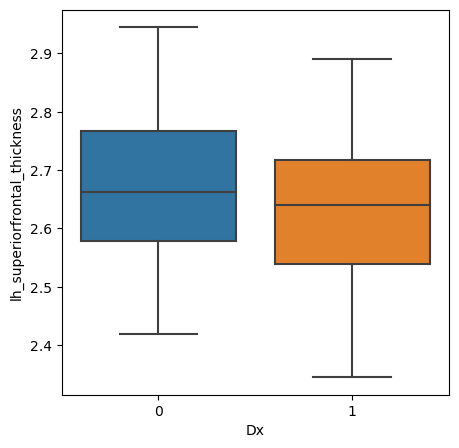

In [58]:
# plot the results as a boxplot
plt.figure(figsize=(5,5))
sns.boxplot(x='Dx', y='lh_superiorfrontal_thickness', data=data)

### Adding some covariates

In [74]:
# econde X adding some covariates
X = data[['Dx', 'Sex', 'Age']]
X = pd.get_dummies(X, drop_first=True)  # make sure that "group" variable is categorical
X = sm.add_constant(X)  # add an intercept
display(X.head())
print('X has shape:', X.shape)

# encode y
y = data['lh_superiorfrontal_thickness']

result = sm.OLS(y, X).fit()
display(result.summary())

,const,Dx,Sex,Age
0,1.0,0,1,35
1,1.0,1,1,52
2,1.0,1,1,53
3,1.0,1,2,48
4,1.0,1,1,28


X has shape: (143, 4)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     lh_superiorfrontal_thickness   R-squared:                       0.289
Model:                                      OLS   Adj. R-squared:                  0.273
Method:                           Least Squares   F-statistic:                     18.81
Date:                          Fri, 17 Jan 2025   Prob (F-statistic):           2.70e-10
Time:                                  15:57:02   Log-Likelihood:                 123.14
No. Observations:                           143   AIC:                            -238.3
Df Residuals:                               139   BIC:                            -226.4
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8097      0.040     69.985      0.000       2.730       2.889
Dx            -0.0450      0.018     -2.546      0.012      -0.080      -0.010
Sex            0.0366      0.020      1.787      0.076      -0.004       0.077
Age           -0.0048      0.001     -6.797      0.000      -0.006      -0.003
==============================================================================
Omnibus:                        1.760   Durbin-Watson:                   2.142
Prob(Omnibus):                  0.415   Jarque-Bera (JB):                1.541
Skew:                          -0.119   Prob(JB):                        0.463
Kurtosis:                       2.551   Cond. No.                         193.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [82]:
mdl = sm.GLM(y, X, family=sm.families.Gamma())
glm_results = mdl.fit()
display(glm_results.summary())

/Users/melissa/anaconda3/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                       
========================================================================================
Dep. Variable:     lh_superiorfrontal_thickness   No. Observations:                  143
Model:                                      GLM   Df Residuals:                      139
Model Family:                             Gamma   Df Model:                            3
Link Function:                    inverse_power   Scale:                       0.0015223
Method:                                    IRLS   Log-Likelihood:                 122.95
Date:                          Fri, 17 Jan 2025   Deviance:                      0.21256
Time:                                  16:01:13   Pearson chi2:                    0.212
No. Iterations:                               5   Pseudo R-squ. (CS):             0.3271
Covariance Type:                      nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3546      0.006     62.632      0.000       0.344       0.366
Dx             0.0064      0.003      2.559      0.010       0.002       0.011
Sex           -0.0051      0.003     -1.764      0.078      -0.011       0.001
Age            0.0007      0.000      6.803      0.000       0.000       0.001
==============================================================================
"""

/Users/melissa/anaconda3/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='Dx', ylabel='lh_superiorfrontal_thickness'>

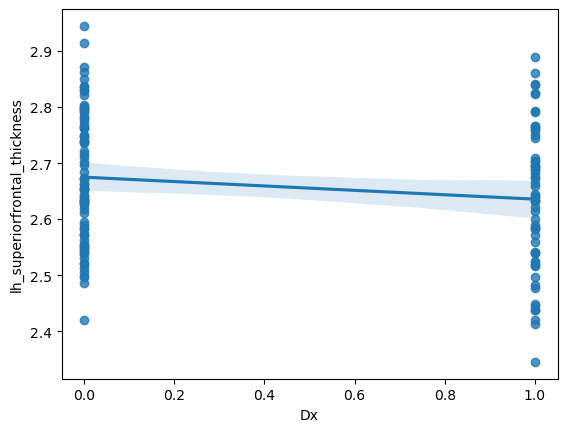

In [85]:
sns.regplot(X['Dx'], y)